In [19]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [20]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [21]:
from model_wizard import buscar_melhor_wisard
from metricas import plot_confusion_matrix, classification_metrics
from tratamento_dados import preprocess_data

## Quinto Dataset

In [26]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dermatology = fetch_ucirepo(id=33) 
  
# data (as pandas dataframes) 
X = dermatology.data.features 
y = dermatology.data.targets 
  
# metadata 
print(dermatology.metadata) 
  
# variable information 
print(dermatology.variables) 


{'uci_id': 33, 'name': 'Dermatology', 'repository_url': 'https://archive.ics.uci.edu/dataset/33/dermatology', 'data_url': 'https://archive.ics.uci.edu/static/public/33/data.csv', 'abstract': 'Aim for this dataset is to determine the type of Eryhemato-Squamous Disease.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 366, 'num_features': 34, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5FK5P', 'creators': ['Nilsel Ilter', 'H. Guvenir'], 'intro_paper': {'ID': 387, 'type': 'NATIVE', 'title': 'Learning differential diagnosis of erythemato-squamous diseases using voting feature intervals', 'authors': 'H. Altay Güvenir, G. Demiröz, N. Ilter', 'venue': 'Artif. Intell. Medicine', 'year': 1998, 'journal': No

### Visualização de datasets

In [27]:
import numpy as np
print("Features:")
print(X.head())
print("\nTargets únicos:")
print(np.unique(y))

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   erythema  scaling  definite-borders  itching  koebner phenomenon  \
0         2        2                 0        3                   0   
1         3        3                 3        2                   1   
2         2        1                 2        3                   1   
3         2        2                 2        0                   0   
4         2        3                 2        2                   2   

   polygonal papules  follicular papules  oral-mucosal involvement  \
0                  0                   0                         0   
1                  0                   0                         0   
2                  3                   0                         3   
3                  0                   0                         0   
4                  2                   0                         2   

   knee elbow involvement  scalp involvement  ...  focal hypergranulosis  \
0                       1                  0  ...                 

### Tratamento de Dados

In [29]:
print("X shape original:", X.shape)
print("y shape original:", y.shape)

# Ajusta y se for DataFrame (transforma em Series)
if isinstance(y, pd.DataFrame):
    y = y.squeeze()

# Elimina linhas com NaN em X ou y antes do preprocessamento
X_y = X.copy()
X_y["__target__"] = y
X_y_clean = X_y.dropna()

# Separa X e y novamente
X_clean = X_y_clean.drop(columns="__target__")
y_clean = X_y_clean["__target__"]

print(f"Apos remoção de NaN, X shape: {X_clean.shape}, y shape: {y_clean.shape}")

# Pré-processamento
X_processed, y_encoded, le = preprocess_data(X_clean, y_clean, categorical_cols, numeric_cols)

print("X_processed shape:", X_processed.shape)
print("y_encoded shape:", y_encoded.shape)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Exibe shapes
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

# Exibe exemplos
print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])


X shape original: (366, 34)
y shape original: (366,)
Apos remoção de NaN, X shape: (358, 34), y shape: (358,)
X_processed shape: (358, 272)
y_encoded shape: (358,)
Tamanho do conjunto de treino: (250, 272)
Tamanho do conjunto de teste: (108, 272)
Tamanho dos rótulos de treino: (250,)
Tamanho dos rótulos de teste: (108,)

Exemplo de X_train (primeiras 5 linhas):
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]

Exemplo de y_train (primeiros 5 rótulos):
[0 0 1 0 1]

Exemplo de X_test (primeiras 5 linhas):
[[1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]]

Exemplo de y_test (primeiros 5 rótulos):
[1 4 0 0 0]


#### Métricas

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Treinando WiSARD com n_classes=6, entry_size=272, tuple_size=8, bleaching=True
Melhores parâmetros encontrados: {'wisard__tuple_size': 8, 'wisard__bleaching': True}
Melhor acurácia: 0.9641422834193918


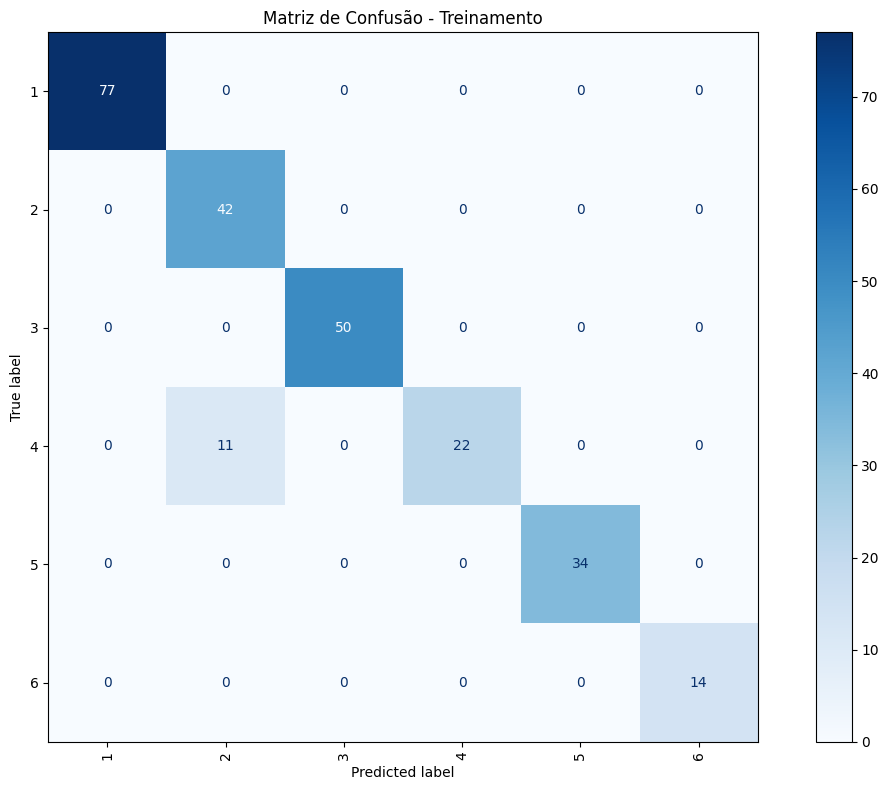

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        77
           2       0.79      1.00      0.88        42
           3       1.00      1.00      1.00        50
           4       1.00      0.67      0.80        33
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        14

    accuracy                           0.96       250
   macro avg       0.97      0.94      0.95       250
weighted avg       0.97      0.96      0.95       250



In [30]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Plota matriz de confusão com labels na vertical
plot_confusion_matrix(y_train, y_train_pred_encoded, le, title="Matriz de Confusão - Treinamento")

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

### Predição

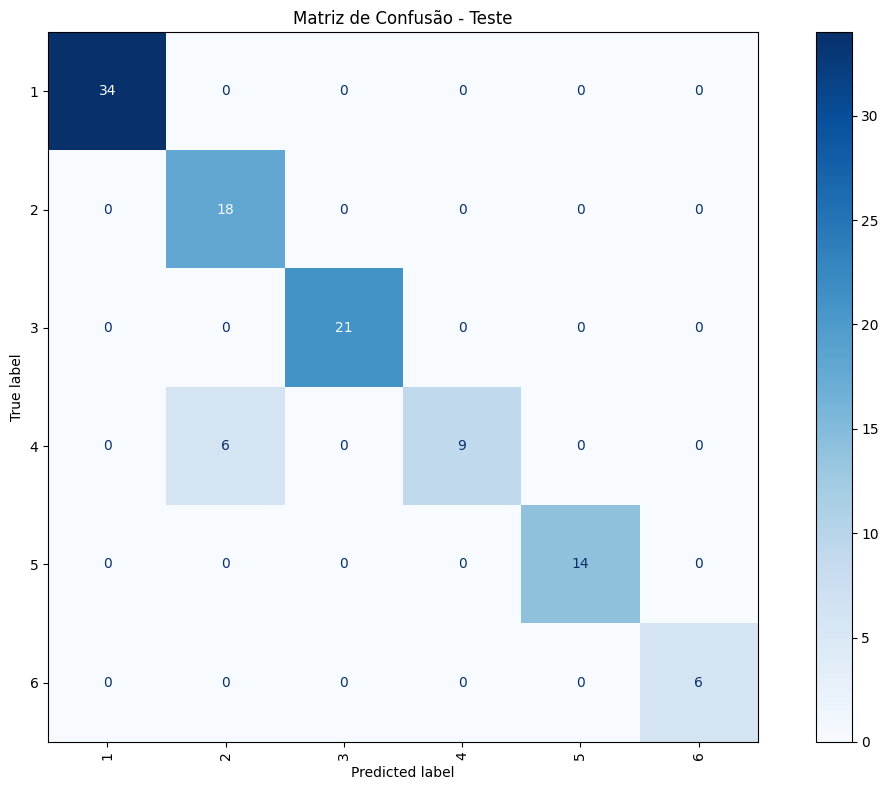

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        34
           2       0.75      1.00      0.86        18
           3       1.00      1.00      1.00        21
           4       1.00      0.60      0.75        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         6

    accuracy                           0.94       108
   macro avg       0.96      0.93      0.93       108
weighted avg       0.96      0.94      0.94       108



In [31]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)